## Imports

In [250]:
import numpy as np
import pandas as pd
from pathlib import Path

In [251]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

In [252]:
import seaborn as sns

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [254]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

## Config

In [255]:
data_fp = Path('../data/')

In [256]:
%matplotlib inline

## Get data

### Read data

In [257]:
example_fp = data_fp.joinpath('gender_submission.csv')
train_fp = data_fp.joinpath('train.csv')
test_fp = data_fp.joinpath('test.csv')

In [258]:
example_raw = pd.read_csv(example_fp)
train_raw = pd.read_csv(train_fp)
test_raw = pd.read_csv(test_fp)

### Summary

In [259]:
example_raw.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [260]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [261]:
test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing

### Separate out data columns

In [262]:
proc_cols = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
train_df = train_raw[proc_cols].set_index('PassengerId')

In [263]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
PassengerId,,,,,,
1,0,3,male,22.0,1,0
2,1,1,female,38.0,1,0
3,1,3,female,26.0,0,0
4,1,1,female,35.0,1,0
5,0,3,male,35.0,0,0


### Pclass

In [264]:
train_proc = train_df.join(pd.get_dummies(train_df['Pclass'], prefix='Pclass')).drop(['Pclass'], axis=1)

### Sex (lol)

In [265]:
train_proc = train_proc.join(pd.get_dummies(train_df['Sex'], prefix='Sex')).drop(['Sex'], axis=1)

### Siblings and Parents

In [266]:
train_proc['Sib?'] = train_proc['SibSp'].apply(lambda n: int(n>0))
train_proc['Par?'] = train_proc['Parch'].apply(lambda n: int(n>0))
train_proc = train_proc.drop(['SibSp', 'Parch'], axis=1)

### Age

In [267]:
train_proc['Age'] = train_proc['Age']
# train_proc['Age'] = train_proc['Age'].astype('int32')

In [268]:
# sns.distplot(train_proc[train_proc['Survived']==0]['Age'], hist=False, rug=True, label='Deed')
# sns.distplot(train_proc[train_proc['Survived']==1]['Age'], hist=False, rug=True, label='Livin')

In [269]:
age_groups = [
    (-1, 0),
    (0, 15),
    (15, 60),
    (60, train_proc['Age'].max()+1)
]

In [270]:
def age_group(age, age_groups):
    for idx, age_group in enumerate(age_groups):
        min_age = age_group[0]
        max_age = age_group[1]
        if age < max_age and age >= min_age:
            return idx
    print(age)

In [271]:
age_max = train_proc['Age'].max()

In [272]:
train_proc['Age'] = train_proc['Age'] / age_max

In [273]:
unsup_data = train_proc[['Survived', 'Age']].dropna()

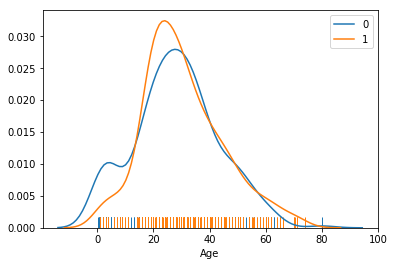

In [274]:
unsup_mdl = KMeans(n_clusters=2)
unsup_mdl.fit(unsup_data)
unsup_preds = unsup_mdl.predict(unsup_data)
res = unsup_data.join(pd.DataFrame(data=unsup_mdl.labels_, columns=['kmeans'], index=unsup_data.index).astype('int16'))
res['Age'] = res['Age'] * age_max
for cluster in set(res['kmeans']):
    sns.distplot(res[res['kmeans']==cluster]['Age'], hist=False, rug=True, label=str(cluster))

In [275]:
train_proc = train_proc.join(res['kmeans']).fillna(-1).drop('Age', axis=1)

In [276]:
train_proc = train_proc.join(pd.get_dummies(train_proc['kmeans'], prefix='kmeans')).drop(['kmeans'], axis=1)

In [277]:
# train_proc['Age'] = train_proc['Age'].apply(lambda x: age_group(x, age_groups))
# train_proc = train_proc.join(pd.get_dummies(train_proc['Age'], prefix='Age')).drop(['Age'], axis=1)

## Modelling

### Data

In [278]:
train_proc.columns

Index(['Survived', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Sib?', 'Par?', 'kmeans_-1.0', 'kmeans_0.0', 'kmeans_1.0'],
      dtype='object')

In [279]:
y_cols = ['Survived']
x_cols = ['Pclass_1', 'Pclass_2', 'Sex_female', 'Sib?', 'Par?'] + [x for x in train_proc.columns if 'kmeans' in x]

In [280]:
X = train_proc.loc[:, x_cols]
y = train_proc.loc[:, y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Models

In [281]:
mdls = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Random Forest Classifier', RandomForestClassifier(n_estimators=100))
]

### Run Models

In [282]:
results = {}
for mdl in mdls:
    name = mdl[0]
    clf = mdl[1]
    results[name] = {}
    
    clf.fit(X_train, y_train.values.ravel())
    
    preds = clf.predict(X_test)
    
    results[name]['model'] = clf
    results[name]['y_pred'] = preds
    results[name]['accuracy'] = accuracy_score(y_test, preds)

### Score Models

In [283]:
for name in results:
    print('%s:\nAccuracy: %.3f\n' % (name, results[name]['accuracy']))

Logistic Regression:
Accuracy: 0.969

Random Forest Classifier:
Accuracy: 0.969



In [284]:
pd.DataFrame(results['Random Forest Classifier']['model'].feature_importances_, 
               index = X_train.columns, 
               columns=['importance']).sort_values('importance', ascending=False)

,importance
kmeans_0.0,0.469955
kmeans_1.0,0.294252
Sex_female,0.124041
kmeans_-1.0,0.050039
Pclass_1,0.028061
Pclass_2,0.013513
Par?,0.013428
Sib?,0.006711


In [285]:
coef = results['Logistic Regression']['model'].coef_
pd.DataFrame(coef.T,
             index = X_train.columns, 
             columns=['coefficients']).sort_values('coefficients', ascending=False)

,coefficients
kmeans_0.0,3.886963
Sex_female,1.988589
Pclass_2,0.671270
Pclass_1,0.453965
Sib?,0.032283
Par?,-0.685896
kmeans_-1.0,-0.833616
kmeans_1.0,-3.993440


In [289]:
results['Logistic Regression']['model'].predict(test_raw[x_cols])

KeyError: "None of [Index(['Pclass_1', 'Pclass_2', 'Sex_female', 'Sib?', 'Par?', 'kmeans_-1.0',\n       'kmeans_0.0', 'kmeans_1.0'],\n      dtype='object')] are in the [columns]"